## Objective
The main goal of this analysis is to create a predictive machine learning model to determine whether the patient has the Parkinson's Disease (PD) or not. The analysis focuses on prediction as a well-performing model with high accuracy. 
This analysis may benefit healthcare workers by improving decision-making and providing a better understanding of the factors that influence the PD.

## Brief description of the data set
The dataset used for this analysis is `parkinson.data`* which is obtained from data-flair and it contains a variety of biomedical voice measurements from 31 people, 23 of whom have Parkinson's disease (PD). Each column in the dataset represents a specific voice measure, and each row corresponds to one of 195 voice recordings from these people ("name" column). The ‘status’ column represents people who are healthy and who has PD.

*Max A. Little, Patrick E. McSharry, Eric J. Hunter, Lorraine O. Ramig (2008), 'Suitability of dysphonia measurements for telemonitoring of Parkinson's disease', IEEE Transactions on Biomedical Engineering (to appear)

#### Summary of Attributes

- __name__ - ASCII subject name and recording number
- __MDVP:Fo(Hz)__ - Average vocal fundamental frequency
- __MDVP:Fhi(Hz)__ - Maximum vocal fundamental frequency
- __MDVP:Flo(Hz)__ - Minimum vocal fundamental frequency
- __MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP__ - Several measures of variation in fundamental frequency
- __MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA__ - Several measures of variation in amplitude
- __NHR,HNR__ - Two measures of ratio of noise to tonal components in the voice
- __status__ - Health status of the subject (one) - Parkinson's, (zero) - healthy
- __RPDE,D2__ - Two nonlinear dynamical complexity measures
- __DFA__ - Signal fractal scaling exponent
- __spread1,spread2,PPE__ - Three nonlinear measures of fundamental frequency variation


#### Loading libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Loading the dataset

In [2]:
#DataFlair - Read the data
df=pd.read_csv('parkinsons.data')
df.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


#### Data exploration and feature engineering

In [3]:
df.describe()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,...,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,154.228641,197.104918,116.324631,0.006220,0.000044,0.003306,0.003446,0.009920,0.029709,0.282251,...,0.046993,0.024847,21.885974,0.753846,0.498536,0.718099,-5.684397,0.226510,2.381826,0.206552
std,41.390065,91.491548,43.521413,0.004848,0.000035,0.002968,0.002759,0.008903,0.018857,0.194877,...,0.030459,0.040418,4.425764,0.431878,0.103942,0.055336,1.090208,0.083406,0.382799,0.090119
min,88.333000,102.145000,65.476000,0.001680,0.000007,0.000680,0.000920,0.002040,0.009540,0.085000,...,0.013640,0.000650,8.441000,0.000000,0.256570,0.574282,-7.964984,0.006274,1.423287,0.044539
25%,117.572000,134.862500,84.291000,0.003460,0.000020,0.001660,0.001860,0.004985,0.016505,0.148500,...,0.024735,0.005925,19.198000,1.000000,0.421306,0.674758,-6.450096,0.174351,2.099125,0.137451
50%,148.790000,175.829000,104.315000,0.004940,0.000030,0.002500,0.002690,0.007490,0.022970,0.221000,...,0.038360,0.011660,22.085000,1.000000,0.495954,0.722254,-5.720868,0.218885,2.361532,0.194052
75%,182.769000,224.205500,140.018500,0.007365,0.000060,0.003835,0.003955,0.011505,0.037885,0.350000,...,0.060795,0.025640,25.075500,1.000000,0.587562,0.761881,-5.046192,0.279234,2.636456,0.252980
max,260.105000,592.030000,239.170000,0.033160,0.000260,0.021440,0.019580,0.064330,0.119080,1.302000,...,0.169420,0.314820,33.047000,1.000000,0.685151,0.825288,-2.434031,0.450493,3.671155,0.527367


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

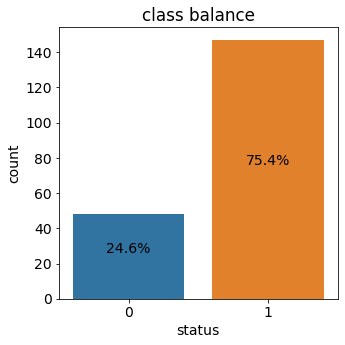

In [5]:
# Check the class balance  
plt.rcParams.update({'font.size': 14})
fig , ax = plt.subplots(figsize =(5,5))
sns.countplot(x=df['status'])
plt.title('class balance')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()/2
    ax.annotate(percentage, (x, y), ha='center', va='center')

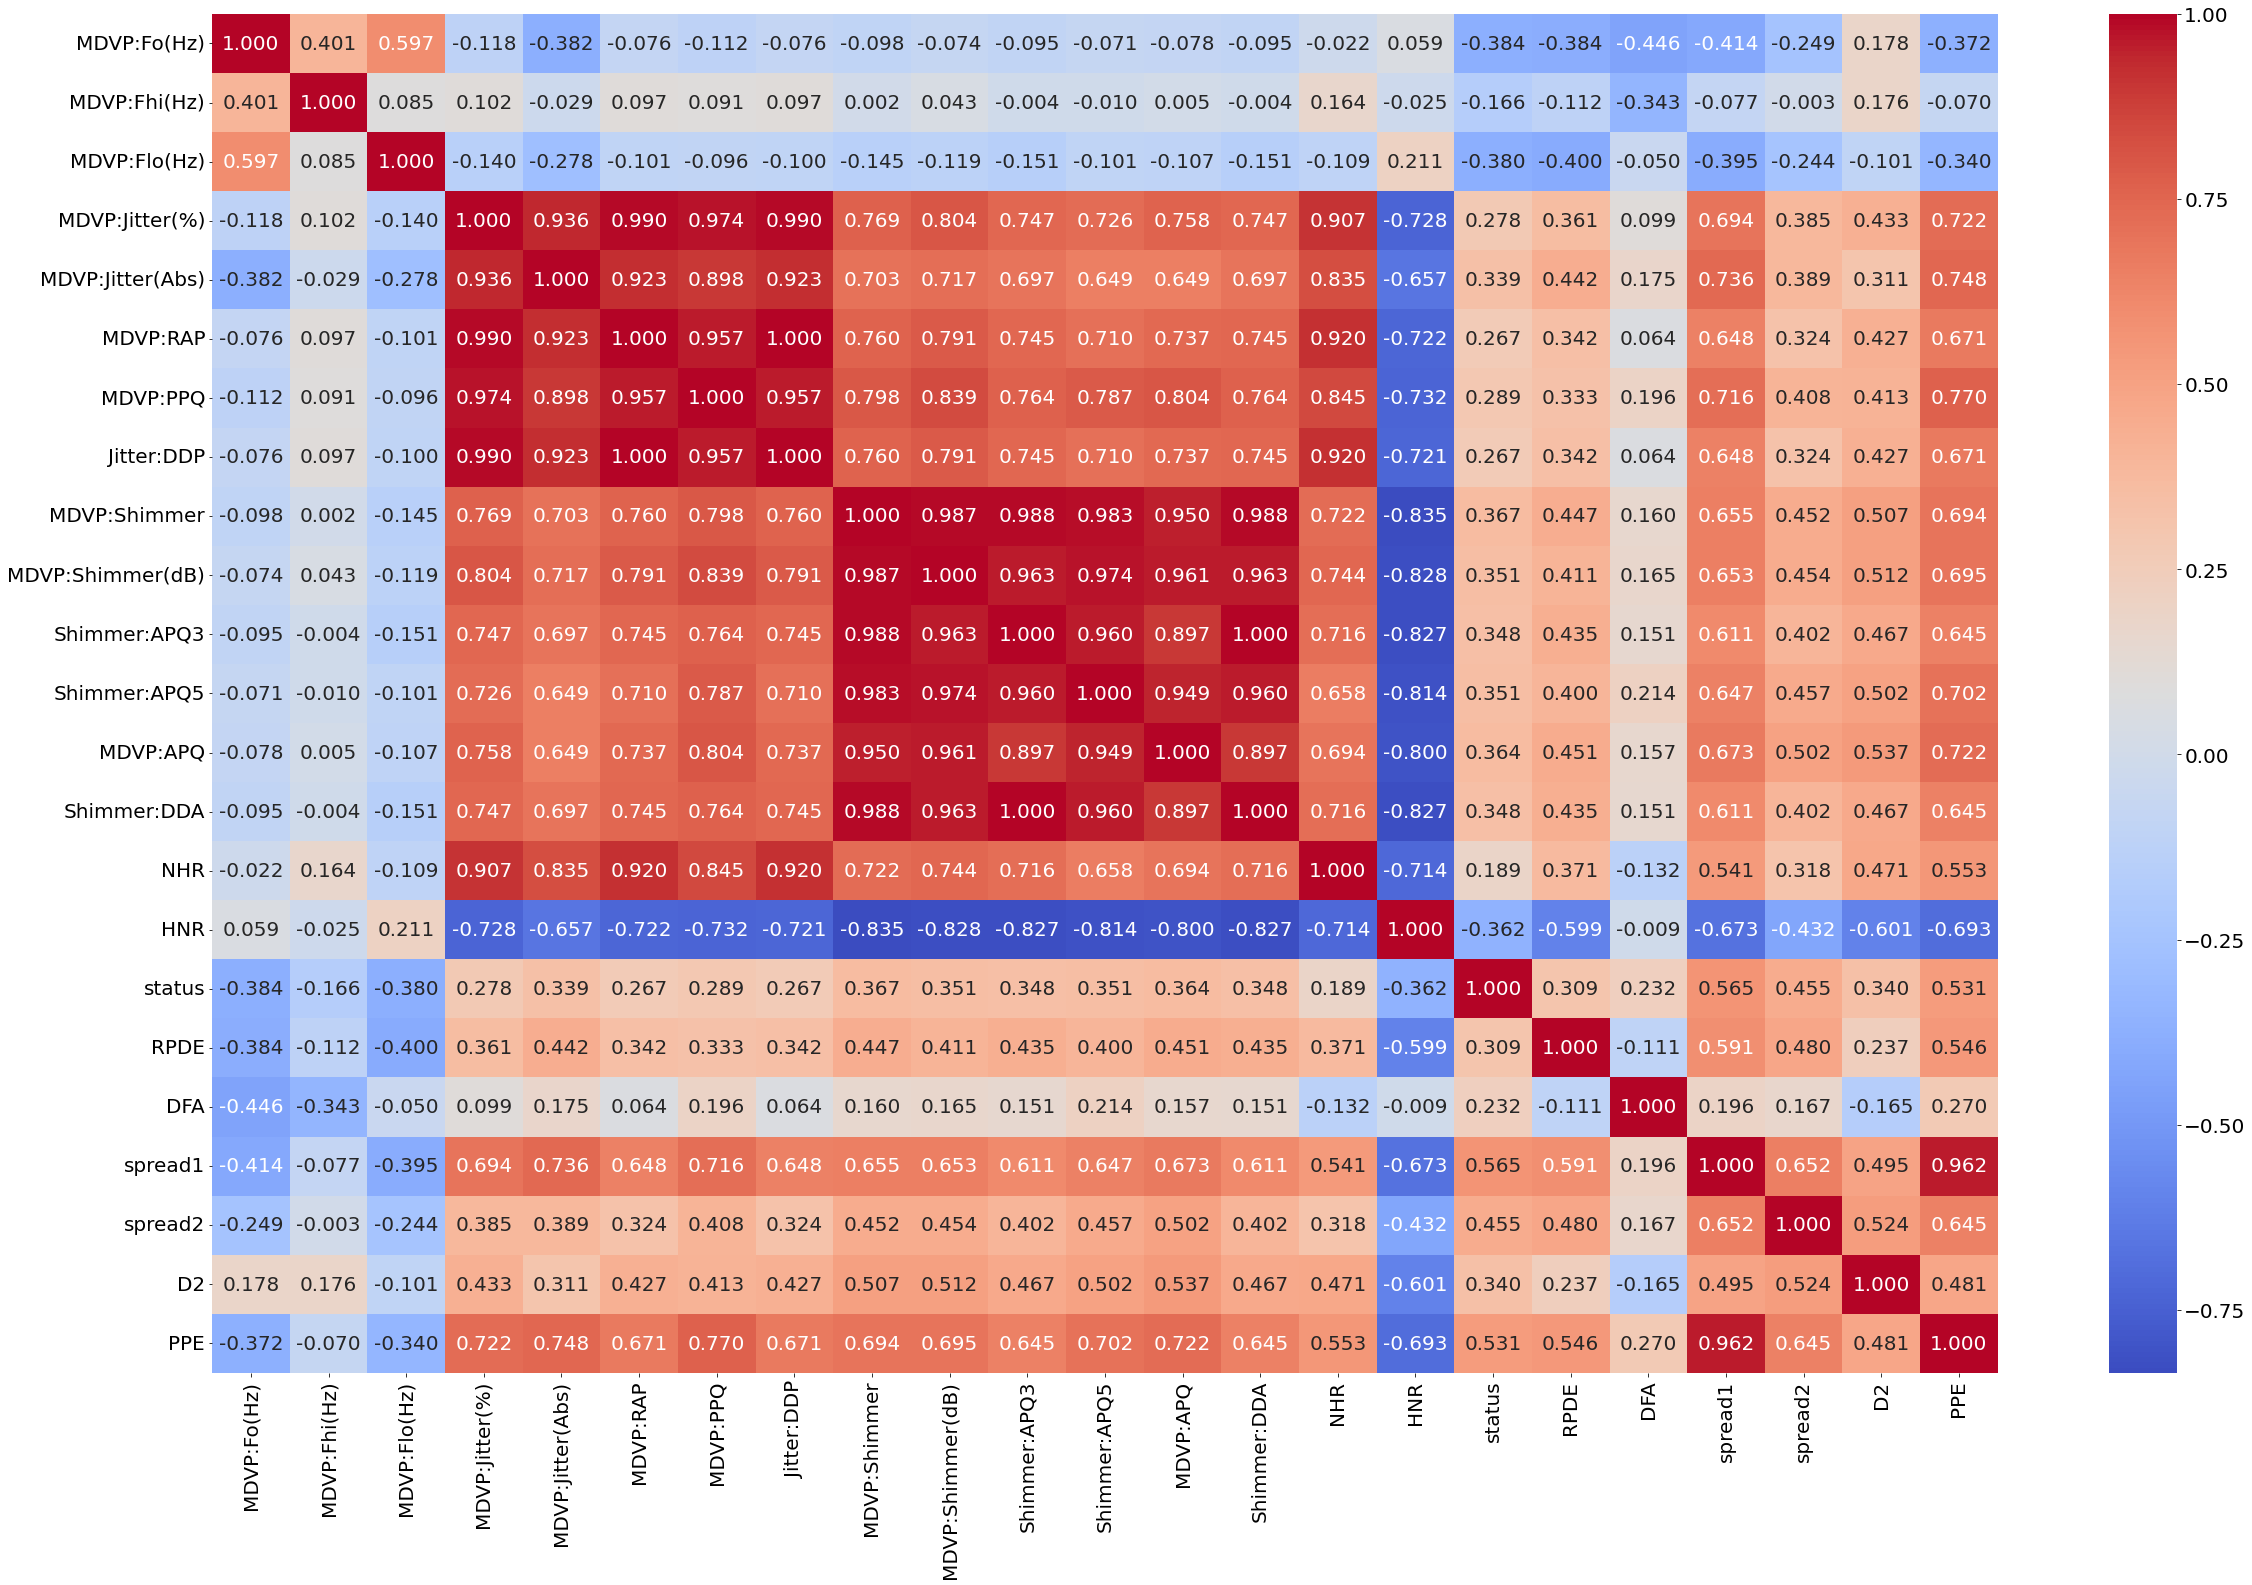

In [6]:
# Compute correlations of each column
corr = df.iloc[:, 1:].corr()
plt.rcParams.update({'font.size': 20})

# Plot correlations
plt.figure(figsize=(40, 25))
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values, 
    annot = True, cmap = "coolwarm", 
    fmt = ".3f");

In [7]:
#drop columns that are highly correlated
df.drop(['MDVP:Jitter(Abs)'], axis=1, inplace=True)
df.drop(['MDVP:RAP'], axis=1,inplace=True)
df.drop(['MDVP:PPQ'], axis=1,inplace=True)
df.drop(['Jitter:DDP'], axis=1,inplace=True)
df.drop(['MDVP:Shimmer(dB)'], axis=1,inplace=True)
df.drop(['Shimmer:APQ3'], axis=1,inplace=True)
df.drop(['Shimmer:APQ5'], axis=1,inplace=True)
df.drop(['MDVP:APQ'], axis=1,inplace=True)
df.drop(['Shimmer:DDA'], axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            195 non-null    object 
 1   MDVP:Fo(Hz)     195 non-null    float64
 2   MDVP:Fhi(Hz)    195 non-null    float64
 3   MDVP:Flo(Hz)    195 non-null    float64
 4   MDVP:Jitter(%)  195 non-null    float64
 5   MDVP:Shimmer    195 non-null    float64
 6   NHR             195 non-null    float64
 7   HNR             195 non-null    float64
 8   status          195 non-null    int64  
 9   RPDE            195 non-null    float64
 10  DFA             195 non-null    float64
 11  spread1         195 non-null    float64
 12  spread2         195 non-null    float64
 13  D2              195 non-null    float64
 14  PPE             195 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 23.0+ KB


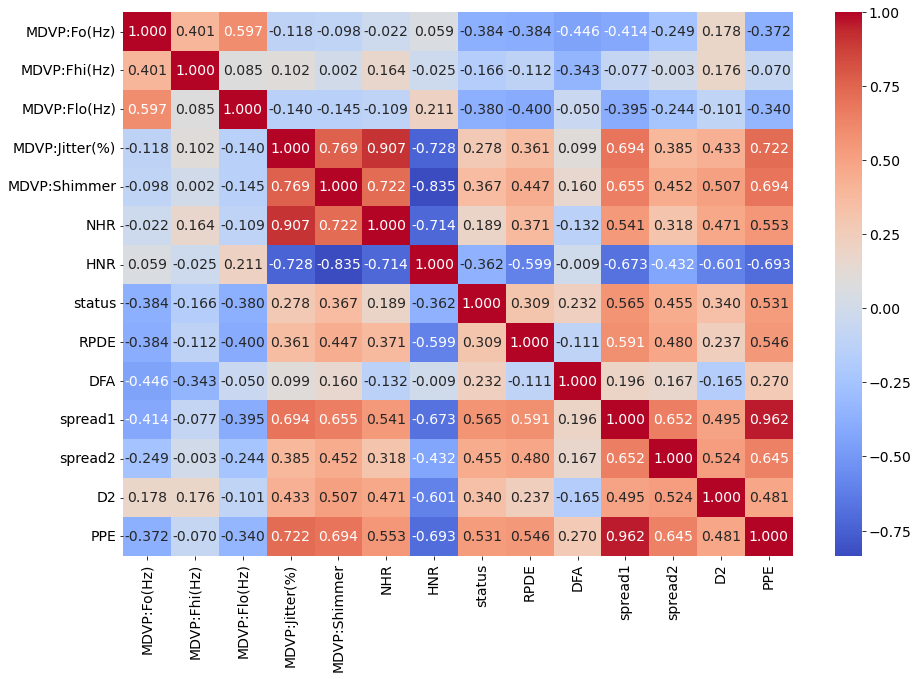

In [8]:
# Compute correlations of each column
corr = df.iloc[:, 1:].corr()
plt.rcParams.update({'font.size': 14})

# Plot correlations
plt.figure(figsize=(15, 10))
sns.heatmap(
    corr, 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values, 
    annot = True, cmap = "coolwarm", 
    fmt = ".3f");

In [9]:
df.columns[1:]

Index(['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)',
       'MDVP:Shimmer', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1',
       'spread2', 'D2', 'PPE'],
      dtype='object')

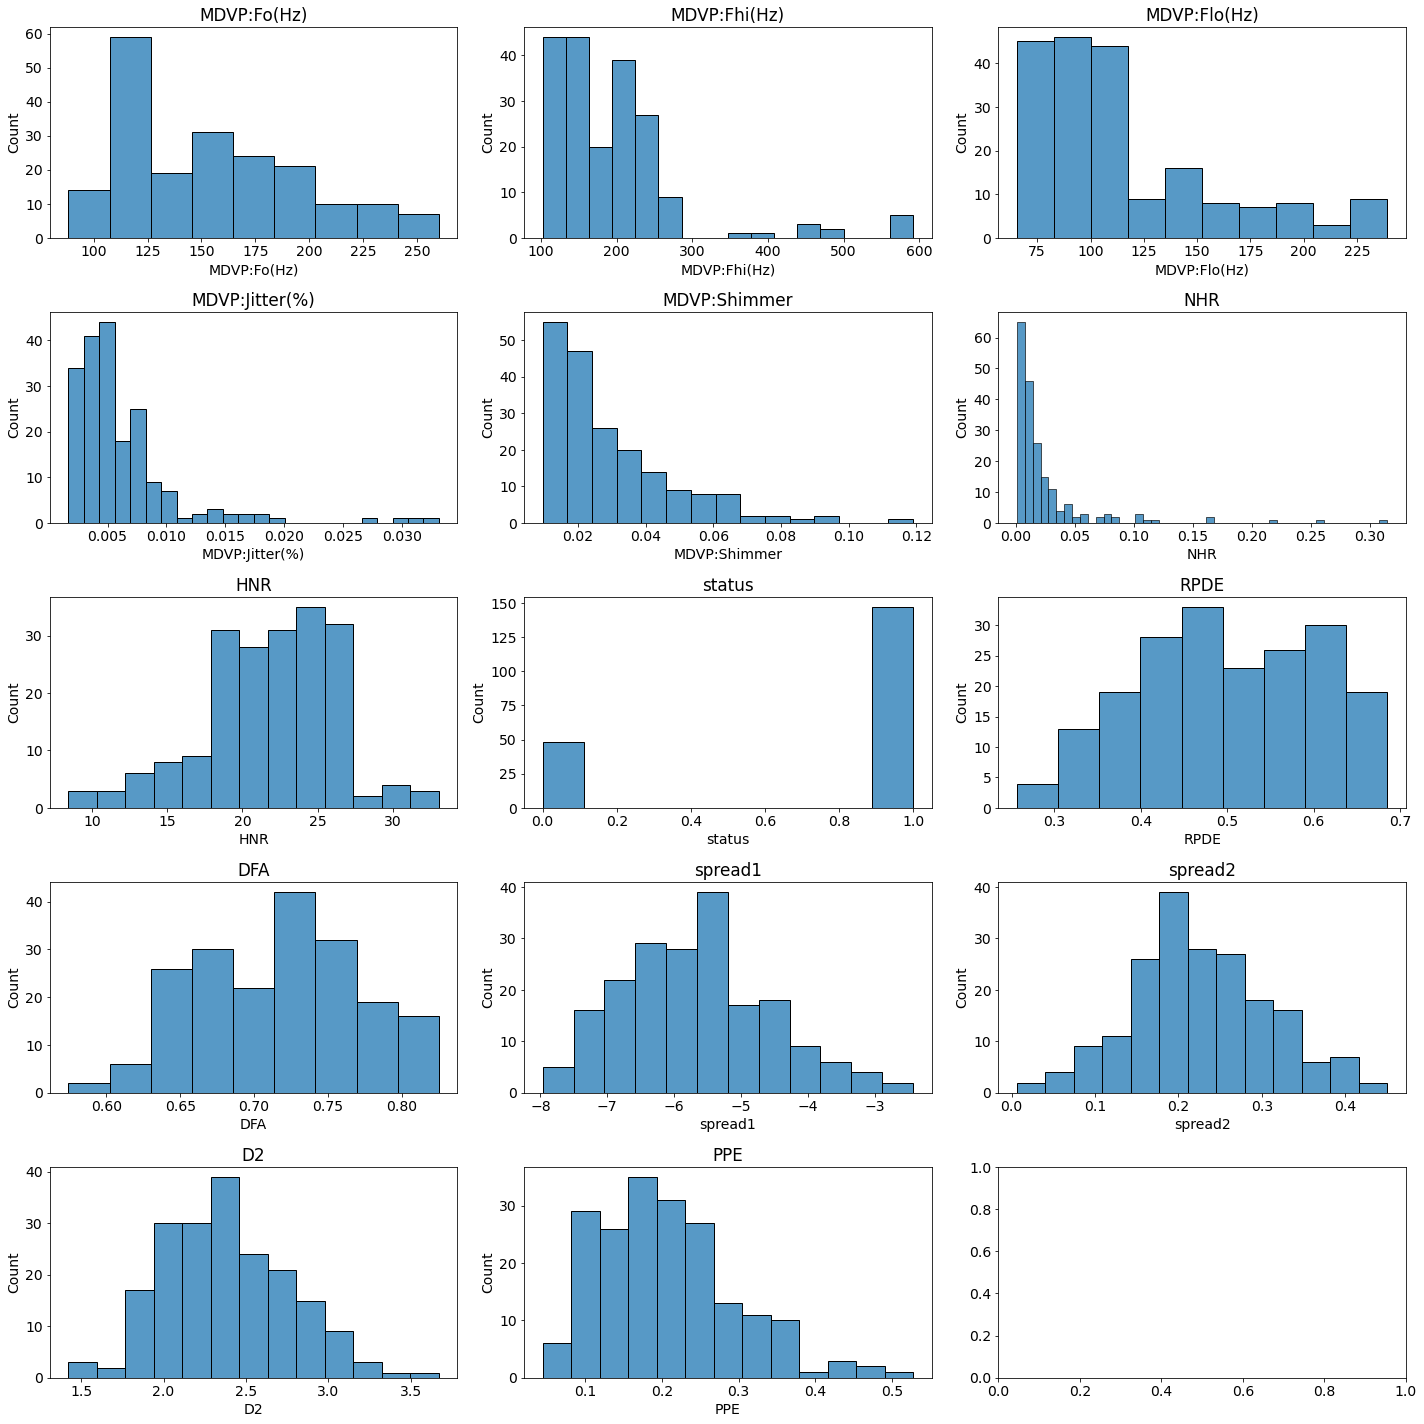

In [10]:
fig, axs = plt.subplots(5, 3, figsize=(20, 20))
axs = axs.ravel()

# Plot histograms for all columns
for i, column in enumerate(df.columns[1:]):
    sns.histplot(df[column], ax=axs[i])
    axs[i].set_title(column)

plt.tight_layout()
plt.show()

In [11]:
#DataFlair - Get the features and labels
features=df.loc[:,df.columns!='status'].values[:,1:]
labels=df.loc[:,'status'].values

In [12]:
#DataFlair - Get the count of each label (0 and 1) in labels
print(labels[labels==1].shape[0], labels[labels==0].shape[0])

147 48


In [13]:
#DataFlair - Scale the features to between -1 and 1
scaler=MinMaxScaler((-1,1))
x=scaler.fit_transform(features)
y=labels

In [14]:
column_names_list1 = df.columns[1:8].tolist()
column_names_list2 = df.columns[9:15].tolist()
new_name_list = column_names_list1 + column_names_list2

In [15]:
df_x=pd.DataFrame(x, columns=new_name_list)

In [16]:
#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, random_state=1)

### Classification Methods

#### Logistic Regression

In [17]:
logreg = LogisticRegression()
logreg.fit(x_train,y_train)

LogisticRegression()

In [18]:
y_pred = logreg.predict(x_test)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[ 7  3]
 [ 2 27]]


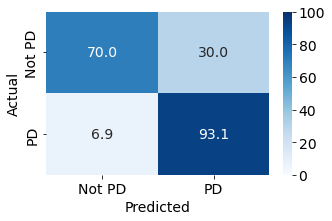

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['Not PD','PD']
cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(cmn*100, annot=True, fmt='.1f', xticklabels=target_names, yticklabels=target_names, cmap="Blues", vmin=0, vmax=100)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### Support Vector Machine

In [21]:
#Import svm model
from sklearn import svm

clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

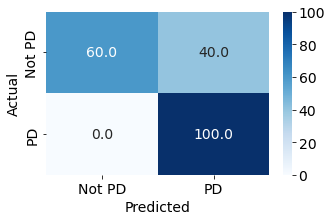

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['Not PD','PD']
cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(cmn*100, annot=True, fmt='.1f', xticklabels=target_names, yticklabels=target_names, cmap="Blues", vmin=0, vmax=100)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

#### XGBoost

In [23]:
#DataFlair - Train the model
model=XGBClassifier()
model.fit(x_train,y_train)
y_pred=model.predict(x_test)

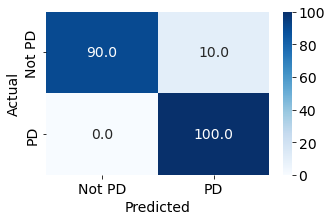

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
target_names=['Not PD','PD']
cm = confusion_matrix(y_test, y_pred)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,3))
sns.heatmap(cmn*100, annot=True, fmt='.1f', xticklabels=target_names, yticklabels=target_names, cmap="Blues", vmin=0, vmax=100)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

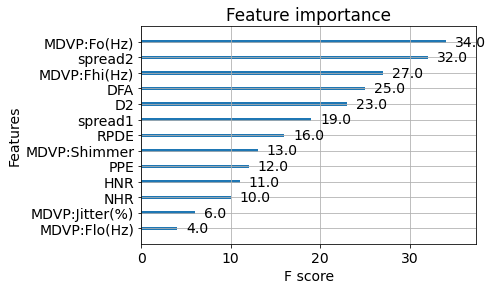

In [25]:
from xgboost import plot_importance
model.get_booster().feature_names = new_name_list
# plot feature importance
plot_importance(model.get_booster())
plt.rcParams["figure.figsize"] = (15, 7)
plt.show()

The evaluation of the performance of the three models shows that XGBoost performed best in terms of accuracy. Therefore, this model is recommended as the final model for this analysis.

The key findings from this analysis is that the most significant impact on the status of the disease are *MDVP:Fo(Hz)* and *spread2* which corresponds to Average vocal fundamental frequency and frequency variation, respectively. 
These insights derived from the classifier model can be used by healthcare workers to make informed decisions and better understand the underlying drivers of the Parkinson’s disease.

__Next steps__
<br>
In the next steps, additional data and data features can be added to achieve even better accuracy in prediction. Additionally, other advanced machine learning techniques such as gradient boosting and neural networks can be explored to further improve the performance of the model.